In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.signal import hilbert
from closedloop.streamer_class import data_streamer
%matplotlib inline


In [2]:
RAW_DATA_FILE = '../test_data/n1_raw.fif'
RAW_EVE_FILE = '../test_data/n1_eve.fif'

CHANNELS = ['F4-C4','C4-A1']

# Sampling Frequency 500 Hz

In [3]:
raw = mne.io.read_raw_fif(RAW_DATA_FILE)
raw_events = mne.read_events(RAW_EVE_FILE)
streamer = data_streamer(raw, raw_events)
streamer.chans_sel(CHANNELS)

stages = streamer.staging()

Opening raw data file ../test_data/n1_raw.fif...


    Range : 0 ... 17309999 =      0.000 ... 34619.998 secs
Ready.


In [4]:
from closedloop.util import find_value_indices
indices_n3 = find_value_indices(stages, 3)

In [5]:
print(indices_n3)

[(375000, 615000), (645000, 2130000), (3360000, 3750000), (4320000, 5685000), (8040000, 8385000), (8445000, 8925000), (13815000, 13920000), (13995000, 14267000)]


In [6]:
from closedloop.util import find_value_indices
indices_n3 = find_value_indices(stages, 3)
print('Taking the first time slice:', indices_n3[0])
# TIMESLICE = (8445000, 8445000 + 15000)
# TIMESLICE = (7200 * 500, (7200 + 60) * 500)
# TIMESLICE = indices_n3[0]
TIMESLICE = (indices_n3[0][1]- 60000, indices_n3[0][1])
# TIMESLICE = (indices_n3[0][1]- 15000, indices_n3[0][1] - 5000)
hypno = stages[TIMESLICE[0]:TIMESLICE[1]]
data_1 = raw.get_data(start=TIMESLICE[0], stop=TIMESLICE[1], picks=CHANNELS)[0] * 1e6
data_2 = raw.get_data(start=TIMESLICE[0], stop=TIMESLICE[1], picks=CHANNELS)[1] * 1e6
data = data_1 + data_2

Taking the first time slice: (375000, 615000)


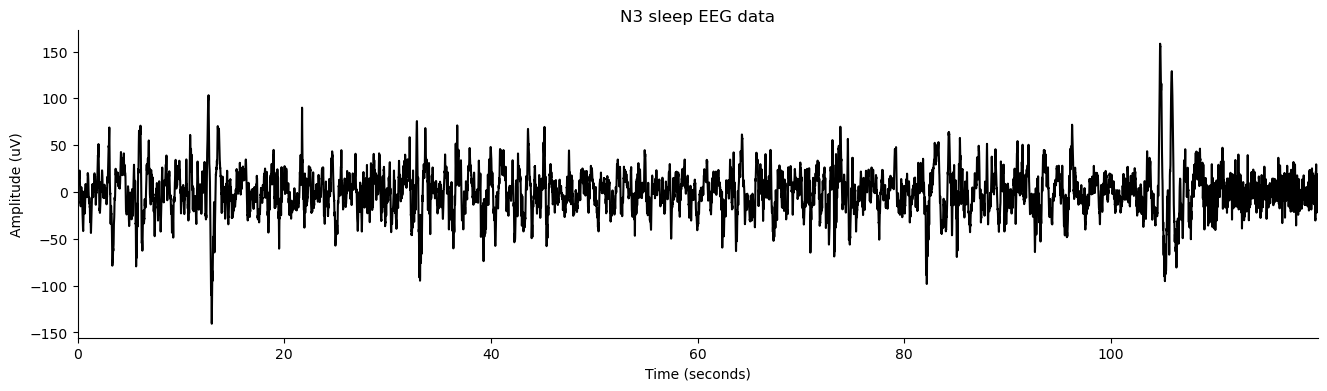

In [7]:
sf = 500.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data')
sns.despine()

In [8]:
from yasa import sw_detect

# Short version
# sw = sw_detect(data, sf, hypno=hypno)

# Long version (with all the optional implicit arguments)
sw = sw_detect(data, sf, hypno=hypno, include=(2, 3), freq_sw=(0.3, 1.5),
               dur_neg=(0.3, 1.5), dur_pos=(0.1, 1.5), amp_neg=(40, 200),
               amp_pos=(10, 150), amp_ptp=(75, 350), coupling=False,
               remove_outliers=False, verbose=False)

# To get the full detection dataframe, we use the .summary() method
events = sw.summary()
# sw_front.compare_detection(sw_central, other_is_groundtruth=True)
events

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,12.810,13.082,13.344,13.568,13.996,1.186,-93.232585,62.300684,155.533269,593.638430,0.843170,3,CHAN000,0
1,32.946,33.198,33.432,33.644,33.928,0.982,-63.691682,50.630242,114.321925,488.555233,1.018330,3,CHAN000,0
2,42.926,43.166,43.382,43.604,43.838,0.912,-42.007899,43.669076,85.676975,396.652663,1.096491,3,CHAN000,0
3,81.900,82.180,82.536,83.148,83.466,1.566,-55.833218,44.981697,100.814916,283.187965,0.638570,3,CHAN000,0
4,95.270,95.692,95.948,96.218,96.654,1.384,-40.090583,42.687526,82.778109,323.351988,0.722543,3,CHAN000,0
5,104.022,104.312,104.504,104.782,105.042,1.020,-45.767858,96.646472,142.414329,741.741299,0.980392,3,CHAN000,0
6,105.042,105.304,105.598,105.874,106.132,1.090,-82.623360,78.830093,161.453453,549.161404,0.917431,3,CHAN000,0
7,106.132,106.358,107.094,107.304,107.488,1.356,-62.532924,28.548081,91.081005,123.751365,0.737463,3,CHAN000,0


In [9]:
# Let's get a mask indicating for each sample
mask = sw.get_mask()
mask

array([0, 0, 0, ..., 0, 0, 0])

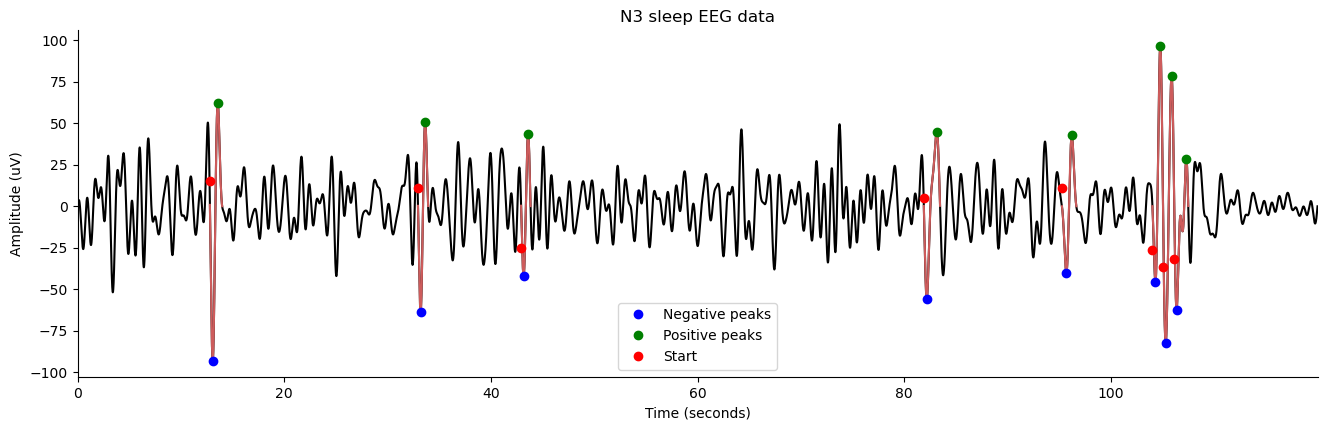

In [10]:
# sw_highlight = data * mask
sw_highlight = sw._data_filt.squeeze() * mask
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))

# plt.plot(times, data, 'k')
plt.plot(times, sw._data_filt.squeeze(), 'k')
plt.plot(times, sw_highlight, 'indianred')
plt.plot(events['NegPeak'], sw_highlight[(events['NegPeak'] * sf).astype(int)], 'bo', label='Negative peaks')
plt.plot(events['PosPeak'], sw_highlight[(events['PosPeak'] * sf).astype(int)], 'go', label='Positive peaks')
plt.plot(events['Start'], data[(events['Start'] * sf).astype(int)], 'ro', label='Start')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N3 sleep EEG data')
plt.legend()
sns.despine()

In [11]:
from closedloop.util import crop_events

info = mne.create_info(['F4-A1', 'staging'], 500., ['eeg', 'misc'])
data_raw = np.vstack((data / 1e6, hypno))
data_raw = mne.io.RawArray(data_raw, info, first_samp=0)
c_event = crop_events(raw_events, 500., TIMESLICE[0] / 500., TIMESLICE[1] / 500)

Creating RawArray with float64 data, n_channels=2, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.


In [12]:
stream = data_streamer(data_raw, c_event)
stream.chans_sel(['F4-A1'])
stream.stages = [3]
stream.buffer_len = 25.
stream.prepare()

Keeping channels: ['F4-A1']
Number of samples in a buffer: 12


In [13]:
from closedloop.cl_loop import thr_detect

listener = thr_detect()
listener.thrs = -65e-6 #-55e-6
listener.twin_len = 5.
listener.fil_low = .3
listener.fil_high = 1.5

n_chunks = int(data_raw.times[-1] / (stream.buffer_len / 1000))
for n in range(n_chunks):
    signal = stream.stream()
    listener.read_buffer(signal)

triggers = np.array(listener.events)

[1, 6708]
[2, 7260]
[1, 16812]
[2, 17340]
[1, 42156]
[2, 42696]
[1, 52356]
[2, 52896]


In [14]:
print(triggers)
loop_ev = triggers[triggers[:, 0] == 0, :]
print(loop_ev)

[[    0  6707]
 [    1  6708]
 [    2  7260]
 [    0 16800]
 [    1 16812]
 [    2 17340]
 [    0 42153]
 [    1 42156]
 [    2 42696]
 [    0 52344]
 [    1 52356]
 [    2 52896]]
[[    0  6707]
 [    0 16800]
 [    0 42153]
 [    0 52344]]


In [15]:
# loop_ev = [[1, 3475],
#            [2, 4050],
#            [1, 11250],
#            [2, 11800],
#            [1, 17850],
#            [2, 18400],
#            [1, 23375],
#            [2, 23925],
#            [1, 25200],
#            [2, 25750],
#            [1, 27125],
#            [2, 27700],
#            [1, 28950],
#            [2, 29500]]
# IIR Filter
# loop_ev = [[1, 18775],
#            [2, 19350],
#            [1, 23925],
#            [2, 24475],
#            [1, 27125],
#            [2, 27675],
#            [1, 28950],
#            [2, 29500]]
# FIR Filter -55e-6Hz
# loop_ev = [[1, 11275],
#            [2, 11825],
#            [1, 17850],
#            [2, 18400],
#            [1, 23375],
#            [2, 23950],
#            [1, 27125],
#            [2, 27675],
#            [1, 28925],
#            [2, 29475]]
# # -60e-6Hz
# loop_ev = [[1, 18775],
#            [2, 19325],
#            [1, 23400],
#            [2, 23925],
#            [1, 27125],
#            [2, 27675],
#            [1, 28950],
#            [2, 29500]]
# # -65e-6
# loop_ev = [[1, 18775],
#            [2, 19325],
#            [1, 23425],
#            [2, 24000],
#            [1, 27125],
#            [2, 27700],
#            [1, 28950],
#            [2, 29500]]
# loop_ev = np.array(loop_ev)

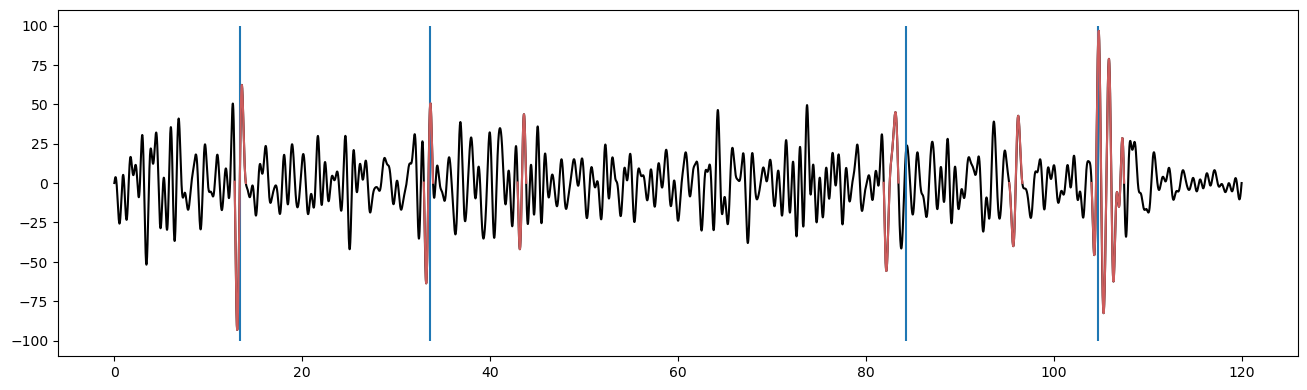

In [16]:
# matplotlib.use('Qt5Agg')
# %matplotlib inline

plt.figure(figsize=(16, 4.5))

# plt.plot(times, data, 'k')
plt.plot(times, sw._data_filt.squeeze(), 'k')
plt.vlines(loop_ev[:, -1] / 500., ymin=-100, ymax=100)
plt.plot(times, sw_highlight, 'indianred')
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 1.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Filter length: 5501 samples (11.002 s)



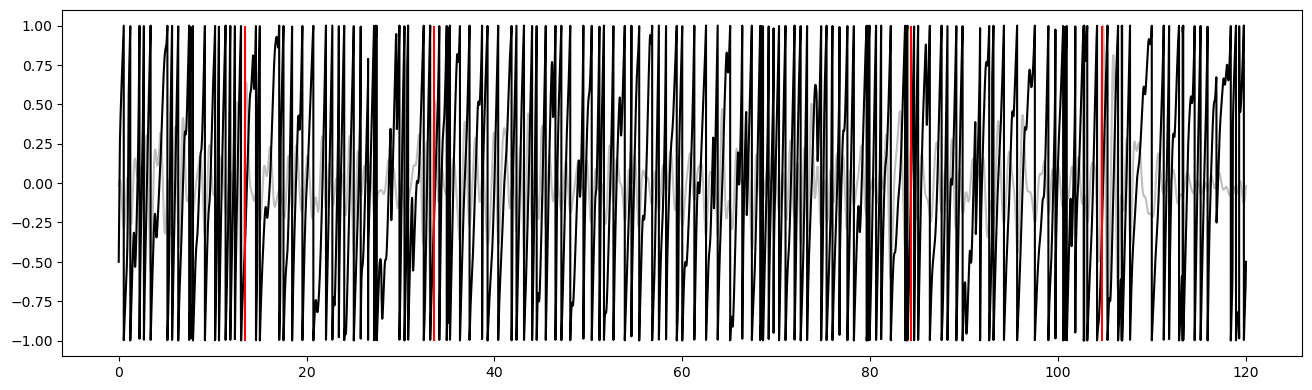

In [17]:
plt.figure(figsize=(16, 4.5))

hilb = hilbert(sw._data_filt.squeeze())
# hilb = hilbert(data)
hilb = data_raw.copy()
hilb = hilb.filter(.3, 1.5)
hilb = hilb.apply_hilbert()
hilb = hilb.pick(['F4-A1']).get_data().squeeze()
phase = np.angle(hilb) / np.pi
# plt.plot(times, data, 'k')
norm_data = 2 * ((sw._data_filt.squeeze() - sw._data_filt.squeeze().min()) / (sw._data_filt.squeeze().max() - sw._data_filt.squeeze().min())) - 1
plt.plot(times, norm_data, 'grey', alpha=.5)
plt.plot(times, phase, 'k')
plt.vlines(loop_ev[:, -1] / 500., ymin=-1, ymax=1, color='red')
# plt.plot(times, sw_highlight, 'indianred')

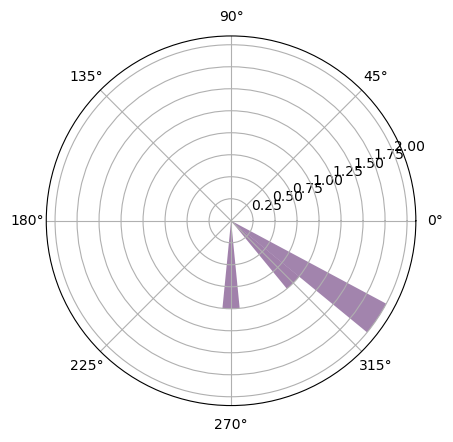

In [18]:
from closedloop.evaluation import get_online_detection_evaluation
import math

n_bins = 32
angles = phase[loop_ev[:, -1]] * np.pi
radii, theta = np.histogram(angles, bins=n_bins, range=(-np.pi, np.pi))
width = (2 * math.pi) / len(radii)
colors = plt.cm.viridis(radii * 3)

# # accuracy, frequencies = get_online_detection_evaluation(phase, loop_ev[:, 1])

# frequencies = phase[loop_ev[:, -1]] * np.pi

# hist = np.histogram(frequencies, bins=360, range=(-np.pi, np.pi))

# # Compute pie slices
# N = len(frequencies)
# theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
# radii = frequencies
# width = (2 * math.pi) / len(hist[-1])
# colors = plt.cm.viridis(radii * 3)

ax = plt.subplot(projection='polar')
ax.bar(theta[:-1], radii, width=width, bottom=0.0, color=colors, alpha=0.5)
# ax = plt.subplot()
# ax.bar(theta, radii, color=colors, alpha=0.5)
# ax = plt.subplot(projection='polar')
# ax.bar(hist[-1][:-1], hist[0], width=width, bottom=0.0, color=colors, alpha=0.5)

plt.show()

In [19]:
print(angles)
print(width)
print(colors)
print(theta)
print(radii)

[-1.40085456 -0.56696836 -0.42401099 -0.74435369]
0.19634954084936207
[[0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.271305 0.019942 0.347269 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.271305 0.019942 0.347269 1.      ]
 [0.274952 0.037752 0.364543 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.  

In [20]:
data

array([10.13462315,  9.70070823,  9.72043472, ..., 10.30948943,
       10.41519727, 10.97786344])

In [21]:
def create_adder(x): 
    def adder(y): 
        return x+y 
 
    return adder 

In [22]:
add_15 = create_adder(15)

In [23]:
add_15

<function __main__.create_adder.<locals>.adder(y)>

In [24]:
add_15(5)

20